# **NLP Project: Enron Email Dataset**

*   **Author:** Matteo Onger
*   **Date:** December 2024

**Dataset documentation**:
*   [Enron email dataset](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset)

**Extra documentation**:
*   [POS](https://universaldependencies.org/u/pos/)
*   [SpaCy - English](https://spacy.io/models/en#en_core_web_sm)

In [ ]:
# ---- LIBRARIES ----
import email
import gensim
import gensim.downloader
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy

from enum import Enum
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from spacy.language import Language
from tqdm.notebook import tqdm
from typing import Any, Literal


# init spacy
flag_gpu = spacy.prefer_gpu()
print(f"GPU available:{flag_gpu}")


# init tpqdm
tqdm.pandas()

GPU available:False


In [ ]:
# ---- FUNCTIONS ----
def extract_fields(msg :email.message, fields :list[str]|None=None) -> dict[str, str]:
    """
    This function extracts the required fields from the given email message.
    If no field is not specified, all the available ones are returned.

    Parameters
    ----------
    msg : email.message
        Email message.
    fields : list | None, optional
        The fields to extract, by default ``None``.

    Returns
    -------
    :dict[str, str]
        A dictionary ``{field_name:field_value}`` containing the fields extracted is returned.

    Notes
    -----
    - If  ``fields`` is ``None``, all the available fields are extracted.
    - Fields must be in lower case.
    """
    res = dict()

    if fields is None:
        res = {str.lower(key):msg[key] for key in msg.keys()}
    else:
        res = {str.lower(key):msg[key] for key in msg.keys() if str.lower(key) in fields}

    if fields is None or "content" in fields:
        parts = list()
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                parts.append(part.get_payload())
        res["content"] = "".join(parts)
    return res


def identity_tokenizer(text):
    """
    Returns ``text`` as it is.
    """
    return text


def remove(lt :list, value :Any) -> list:
    """
    Returns a copy of the given list without the given value.

    Parameters
    ----------
    lt : list
        List to modify.
    value : Any
        Value to remove.

    Returns
    -------
    :list
        A new list without ``value``.
    """
    lt_copy = list(lt)
    lt_copy.remove(value)
    return lt_copy


def split_email_addresses(addresses :str) -> list[str]:
    """
    Extracts the email addresses contained in the provided string.

    Parameters
    ----------
    addresses : str
        String containing email addresses.

    Returns
    -------
    :list[str]
        List of strings that are the email addresses found.

    Notes
    -----
    - If ``addresses`` is not a string, an empty list is returned.
    """
    if isinstance(addresses, str):
        addrs = re.findall(r'[\w.+-]+@[\w-]+\.[\w.-]+', addresses)
    else:
        addrs = list()
    return addrs

In [ ]:
# ---- CLASSES ----
class Preprocessor():
    """
    This class implements a simple preprocessor to split documents into lists of tokens.
    It is mainly based on spaCy.
    """

    class CREIL(Enum):
        """
        Common regex of invalid lines.
        """
        HEADER = r"^\s*(?:-{5,}|.*-{5,}|from:|to:|cc:|ccn:|sent by:|subject:).*$"
        """
        Removes (forwarded, etc.) email header and blank lines.
        """

    class CREIT(Enum):
        """
        Common regex of invalid tokens.
        """
        ALPHA_2 = r"^(?:.*[^a-z_]{1,}.*|.)$"
        """
        Only tokens of two or more characters consisting only of alphabetic characters are retained.
        """
        ALPHANUM = r".*(?:\W|_).*"
        """
        Removes tokens that contain non-alphanumeric characters.
        """


    @Language.component("lower_case_lemmas")
    def _lower_case_lemmas(doc :spacy.tokens.Doc) -> spacy.tokens.Doc:
        """
        Changes the capitalization of the lemmas to lowercase.

        Parameters
        ----------
        doc : spacy.tokens.Doc
            Doc to modify.

        Returns
        -------
        :spacy.tokens.Doc
            Doc modified.
        """
        for token in doc :
            token.lemma_ = token.lemma_.lower()
        return doc


    def __init__(
        self,
        case_sensitive :bool=True,
        lemmatize :bool=False,
        noun_chunks :bool=False,
        keep_stopwords :bool=True,
        extend_stopwords :set[str]=None,
        regex_flags :int=0,
        regex_invalid_line :'str|Preprocessor.CREIL'=None,
        regex_invalid_tokens :'str|Preprocessor.CREIT'=None,
        ent_to_keep :set[str]=None,
        ent_to_rm :set[str]=None,
        pos_to_keep :set[str]=None,
        pos_to_rm :set[str]=None,
    ):
        """
        Parameters
        ----------
        case_sensitive : bool, optional
            If ``False``, all returned tokens are lowercase, by default ``True``.
        lemmatize : bool, optional
            If ``True``, tokens are lemmatized, by default ``False``.
        noun_chunks : bool, optional
            If ``True``, chunk nouns are merged, by default ``False``.
        keep_stopwords : bool, optional
            If ``True``, stop words are kept, by default ``False``.
        extend_stopwords : set[str], optional
            List of stop words to add, by default ``None``.
        regex_flags : int, optional
            Flags of the regular expressions, by default ``0``.
        regex_invalid_line : str|Preprocessor.CREIL, optional
            Regex to mark lines that must be excluded, by default ``None``.
        regex_invalid_tokens : str|Preprocessor.CREIT, optional
            Regex to mark tokens that must to be excluded, by default ``None``.
        ent_to_keep : set[str], optional
            Only tokens marked with one of these entity tags are kept,
            by default all tokens are retained.
        ent_to_rm : set[str], optional
            Tokens marked with one of these entity tags are removed,
            by default all tokens are retained.
        pos_to_keep : set[str], optional
            Only tokens marked with one of these POS tags are kept,
            by default all tokens are retained.
        pos_to_rm : set[str], optional
            Tokens marked with one of these POS tags are removed,
            by default all tokens are retained.
        """
        self.nlp = spacy.load('en_core_web_sm')

        # update nlp piepline
        if not lemmatize and not noun_chunks:
            self.nlp.remove_pipe("lemmatizer")
            if ent_to_keep is None and ent_to_rm is None and pos_to_keep is None and pos_to_rm is None:
                self.nlp.remove_pipe("tagger")
                self.nlp.remove_pipe("parser")
                self.nlp.remove_pipe("attribute_ruler")
                self.nlp.remove_pipe("ner")
        if noun_chunks:
            self.nlp.add_pipe("merge_noun_chunks")
        if lemmatize and not case_sensitive:
            self.nlp.add_pipe("lower_case_lemmas", name="lower_case_lemmas")

        # standard regex
        self.regex_empty_line = r"^\s*$"
        self.regex_endline_1 = r"(=20\n)"
        self.regex_endline_2 = r"(=\n)"

        self.pattern_empty_line = re.compile(self.regex_empty_line, regex_flags)
        self.pattern_endline_1 = re.compile(self.regex_endline_1, regex_flags)
        self.pattern_endline_2 = re.compile(self.regex_endline_2, regex_flags)

        # save fields
        self.case_sensitive = case_sensitive
        self.noun_chunks = noun_chunks
        self.lemmatize = lemmatize
        self.keep_stopwords = keep_stopwords
        self.extend_stopwords = extend_stopwords
        self.regex_flags = regex_flags
        self.regex_invalid_line = regex_invalid_line.value if isinstance(regex_invalid_line, Preprocessor.CREIL) else regex_invalid_line
        self.regex_invalid_tokens = regex_invalid_tokens.value if isinstance(regex_invalid_tokens,  Preprocessor.CREIT) else regex_invalid_tokens
        self.ent_to_keep = ent_to_keep
        self.ent_to_rm = ent_to_rm
        self.pos_to_keep = pos_to_keep
        self.pos_to_rm = pos_to_rm

        # assemble the condition that tokens/lines must satisfy
        self.conditions = list()
        if not keep_stopwords:
            self.conditions.append(lambda x: not x.is_stop)
            if extend_stopwords is not None:
                if lemmatize:
                    self.conditions.append(lambda x: x.lemma_ not in extend_stopwords)
                else:
                    self.conditions.append(lambda x: x.text not in extend_stopwords if case_sensitive else x.text.lower() not in extend_stopwords)
        if ent_to_keep is not None:
            self.conditions.append(lambda x: x.ent_type_ in ent_to_keep)
        if ent_to_rm is not None:
            self.conditions.append(lambda x: x.ent_type_ not in ent_to_rm)
        if pos_to_keep is not None:
            self.conditions.append(lambda x: x.pos_ in pos_to_keep)
        if pos_to_rm is not None:
            self.conditions.append(lambda x: x.pos_ in pos_to_rm)

        if regex_invalid_line is not None:
            self.pattern_invalid_line = re.compile(self.regex_invalid_line, regex_flags)
        if regex_invalid_tokens is not None:
            self.pattern_invalid_tokens = re.compile(self.regex_invalid_tokens, regex_flags)
            self.conditions.append(lambda x: not self.pattern_invalid_tokens.match(x.text))
        return


    def preprocess(self, document :str) -> list[str]:
        """
        Applies the preprocessing procedure to the given document.

        Parameters
        ----------
        document : str
            Document to process.

        Returns
        -------
        :list[str]
            List of tokens representing the document.
        """
        # MIME protocol for base64, the max line length in the encoded data is 76 characters
        # an '=' sign at the end of an encoded line is used to tell the decoder that the line is to be continued,
        # while an '=20' sign is used to tell the line ends
        document = self.pattern_endline_1.sub("\n", document)
        document = self.pattern_endline_2.sub("", document)

        # read the document line by line and remove the invalid ones that are:
        # - blank lines
        # - lines that match the given regex <self.regex_invalid_line>
        # - lines preceded by invalid non-white lines
        prev = True
        filtered_document = list()
        for line in document.splitlines():
            if self.pattern_empty_line.match(line):
                prev = True
            elif prev and (self.regex_invalid_line is None or not self.pattern_invalid_line.match(line)):
                filtered_document.append(line)
            else:
                prev = False

        # replace all withespaces with a single whitespace
        document = re.sub(r"\s{1,}", " ", "\n".join(filtered_document))

        # tokenize, etc. using spaCy
        doc = self.nlp(document)
        if self.lemmatize:
            tokens = [tk.lemma_ for tk in doc if all(f(tk) for f in self.conditions)]
        else:
            if self.case_sensitive:
                tokens = [tk.text for tk in doc if all(f(tk) for f in self.conditions)]
            else:
                tokens = [tk.text.lower() for tk in doc if all(f(tk) for f in self.conditions)]
        return tokens



class KMeansHelper():
    """
    This class is based on the module ``sklearn.cluster.KMeans`` and
    provides some heuristicher to estimate the best number of clusters.
    """

    def __init__(
        self,
        init :str="k-means++",
        n_init :int|str="auto",
        random_state :int=None
    ):
        """
        Parameters
        ----------
        init : str, optional
            Method for initialization, by default ``'k-means++'``:
            - ``'k-means++'``: selects initial cluster centroids using sampling based on an empirical probability distribution
            of the points' contribution to the overall inertia. This technique speeds up convergence.
            The algorithm implemented is greedy k-means++. It differs from the vanilla k-means++ by making several trials
            at each sampling step and choosing the best centroid among them.
            - ``'random'``: choose n_clusters observations at random from data for the initial centroids.
        n_init : str, optional
            Number of times the k-means algorithm is run with different centroid seeds.
            By default ``n_init='auto'``, the number of runs depends on the value of init:
            10 if using ``init='random'``; 1 if using ``init='k-means++'``.
        random_state : int, optional
            Determines random number generation for centroid initialization. Use an int to make the randomness deterministic,
            by default ``None``.
        """
        self.init = init
        self.n_init = n_init
        self.random_state = random_state
        return


    def elbow_method(self, X :np.ndarray, min_K :int, max_K :int) -> dict[int, int]:
        """
        Returns and draws the inertia as the number of clusters changes.
        This heuristic is used to determine the number of clusters in a data set ``X``.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        min_K : int
            Minimum number of clusters.
        max_K : int
            maximum number of clusters.

        Returns
        -------
        :dict[int, int]
            A dictionary containing the SSE for every possible number of clusters
            between ``min_K`` and ``max_K``.
        """
        sse = {}
        for k in range(min_K, max_K):
            kmeans = KMeans(n_clusters=k, init=self.init, n_init=self.n_init, random_state=self.random_state).fit(X)
            sse[k] = kmeans.inertia_

        plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()), marker='*')
        plt.title("Elbow method")
        plt.xlabel("Number of cluster (K)")
        plt.ylabel("SSE")
        plt.show()
        return sse


    def fit_predict(self, X :np.ndarray, K :int) -> tuple[np.ndarray, np.ndarray]:
        """
        Compute cluster centers and predict cluster index for each sample.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        K : int
            Number of clusters.

        Returns
        -------
        :tuple[np.ndarray, np.ndarray]
            Index of the cluster each sample belongs to and the centroids
        """
        kmeans = KMeans(n_clusters=K, init=self.init, n_init=self.n_init, random_state=self.random_state)
        clusters = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        return clusters, centroids


    def silhouette_score(self, X :np.ndarray, min_K :int, max_K :int) -> dict[int, int]:
        """
        Returns the silhouette score [-1, 1] as the number of clusters changes.
        This heuristic is used to determine the number of clusters in a data set ``X``.

        Parameters
        ----------
        X : np.ndarray
            New data to transform.
        min_K : int
            Minimum number of clusters.
        max_K : int
            maximum number of clusters.

        Returns
        -------
        :dict[int, int]
            A dictionary containing the silhouette score for every possible number of clusters
            between ``min_K`` and ``max_K``.
        """
        sc = {}
        print("Number of clusters:")
        for k in range(min_K, max_K):
            kmeans = KMeans(n_clusters=k, init=self.init, n_init=self.n_init, random_state=self.random_state).fit(X)
            sc[k] = silhouette_score(X, kmeans.labels_, metric='euclidean')
            print(f" - K:{k} => Silhouette coeff.: {sc[k]}")
        return sc



class myDoc2Vec():
    """
    This class maps a document to a vector using a weighted average of the vectors
    associated with the tokens that constitute the document under consideration.
    """

    def __init__(self, w2v :gensim.models.KeyedVectors, tfidf_vectorizer :TfidfVectorizer):
        """
        Parameters
        ----------
        w2v : gensim.models.KeyedVectors
            Word vectors to use.
        tfidf_vectorizer : TfidfVectorizer
            Vectorizer to use to compute the TF-IDF score.
        """
        self.w2v = w2v
        self.tfidf_vectorizer = tfidf_vectorizer
        return


    def transform(self, tokenized_corpus :list[list[str]]) -> np.ndarray:
        """
        For each document in the corpus, the function computes a vector representing it.
        The vectors produced lie in the same space defined by the word vectors provided
        during the object initialization.

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.

        Returns
        -------
        :np.ndarray
            A vector for each document.
        """
        corpus_size = len(tokenized_corpus)
        weights_corpus = self.get_weights(tokenized_corpus)

        res = np.zeros((corpus_size, self.w2v.vector_size))
        for i in range(corpus_size):
            # list of unique tokens in i-th doc
            # duplicated tokens are considered only once
            unique_tokens = list(weights_corpus[i].keys())

            # weight of each token
            weights = list(weights_corpus[i].values())

            # weighted mean
            if len(unique_tokens) != 0:
                res[i] = self.w2v.get_mean_vector(unique_tokens, weights=weights)
        return res


    def get_weights(self, tokenized_corpus :list[list[str]], exp :float=5) -> list[dict[str, float]]:
        """
        Computes the weight of each token in each document.
        The weight of the token tk in document doc is as follows: (tfidf(tk, doc) * average similarity(tk, other tokens in doc)))**alpha

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.
        exp : float, optional
            Exponent value, by default ``5``.

        Returns
        -------
        :list[dict[str, float]]
            The weight of each token in each document.
        """
        corpus_size = len(tokenized_corpus)

        tfidf_corpus = self.tfidf_vectorizer.fit_transform(tokenized_corpus)
        tf_corpus = normalize(tfidf_corpus / self.tfidf_vectorizer.idf_)

        weights_corpus = list()
        for i in range(corpus_size):
            # term frequency of tokens in i-th document
            tf_doc = tf_corpus[i].data

            # list of unique tokens in i-th document and their position in the tfidf matrix
            # duplicated tokens are considered only once
            idx_unique_tokens = tf_corpus[i].nonzero()[1]
            unique_tokens = list(
                self.tfidf_vectorizer.get_feature_names_out()[idx_unique_tokens]
            )

            # compute the weight of each token in i-th document
            weights = dict()

            if len(unique_tokens) == 1:
                weights[unique_tokens[0]] = 1.0
            else:
                for k, (j, tk) in enumerate(zip(idx_unique_tokens, unique_tokens)):
                    weights[tk] = (
                        tfidf_corpus[i, j] * np.average(1 - self.w2v.distances(tk, remove(unique_tokens, tk)) / 2, weights=np.delete(tf_doc, k))
                    )**exp
            weights_corpus.append(weights)
        return weights_corpus


    def get_most_similar(self, tokenized_corpus :list[list[str]], topn :int=10) -> list[list[tuple[str, float]]]:
        """
        Equivalent to calling the function ``self.w2v.most_similar`` on the vectors
        returned by ``self.transform``.

        Parameters
        ----------
        tokenized_corpus : list[list[str]]
            Corpus, already tokenized, to be analyzed.
        topn : int, optional
            Number of most similar keys to return, by default ``10``.

        Returns
        -------
        :list[list[tuple[str, float]]]
            The ``top-n`` most similar keys found for each document.

        Notes
        -----
        - Finding the most similar keys for each vector is a slow operation;
        if you are only interested in a few documents, it is better to call ``self.transform``
        and then call ``self.w2v.most_similar`` only on the documents of interest.
        """
        corpus_size = len(tokenized_corpus)

        # weighted mean vectors
        wm_vectors = self.transform(tokenized_corpus)

        res = list()
        for i in range(corpus_size):
            res.append(
                self.w2v.most_similar(wm_vectors[i], topn=topn)
            )
        return res

## Corpus

In [ ]:
# ---- DATASET ----
# download latest version
path = kagglehub.dataset_download("wcukierski/enron-email-dataset")
print(f"Path to dataset files: {path}")

# read the dataset
df = pd.read_csv(path + "/emails.csv")

# from string to email.message
df["message"] = df["message"].apply(lambda x: email.message_from_string(x))

# extract main fields
df = df.join(
    df.apply(
        lambda row: extract_fields(row.message, ["message-id", "date", "from", "to", "subject", "content"]),
        axis='columns',
        result_type='expand'
    )
)

# drop unused column and duplicated messages
df.drop(columns=["message"], inplace=True)
df.drop_duplicates(["content"], keep="first", inplace=True)

# split addresses into a list of strings
df["from"] = df["from"].apply(
    lambda x: split_email_addresses(x),
)
df["to"] = df["to"].apply(
    lambda x: split_email_addresses(x),
)

100%|██████████| 358M/358M [00:02<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wcukierski/enron-email-dataset/versions/2


In [ ]:
# minimum and maximum length (in characters) of emails to be analyzed
min_len, max_len = 2300, 2700

corpus = df[df["content"].apply(lambda x: len(x)).between(min_len, max_len)]

display(corpus)
print(f"\nRandom exemple =>\n{corpus.sample(1).iloc[0, 6]}")

## Tokenizer

In [ ]:
pp = Preprocessor(
    case_sensitive = False,
    lemmatize = True,
    noun_chunks = False,
    keep_stopwords = False,
    extend_stopwords = {"email", "mail", "hereto", "link", "pm", "recipient", "sender", "thank", "thanks", "thereto", "time"},
    regex_flags = re.IGNORECASE,
    regex_invalid_line = Preprocessor.CREIL.HEADER,
    regex_invalid_tokens = Preprocessor.CREIT.ALPHA_2,
    pos_to_keep = {"NOUN"},
    ent_to_rm = {"DATE", "TIME"}
)

tokenized_corpus = list(corpus["content"].progress_apply(pp.preprocess))

  0%|          | 0/8420 [00:00<?, ?it/s]

## TF-IDF

In [ ]:
# skip tokens that do not have a relative document frequency in this range
min_df = 0.01
max_df = 1.00

tfidf_vectorizer =  TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, min_df=min_df, max_df=max_df)
tfidf_corpus = tfidf_vectorizer.fit_transform(tokenized_corpus)

tfidf_df = pd.DataFrame(tfidf_corpus.toarray(), index=corpus.index, columns=tfidf_vectorizer.get_feature_names_out())
display(tfidf_df)

,ability,acceptance,access,account,accounting,acquisition,action,activity,addition,address,...,web,website,week,weekend,woman,word,work,workshop,world,year
23,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
40,0.000000,0.0,0.0,0.071336,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
66,0.151543,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.235612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
283,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
397,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517220,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
517221,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
517275,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
517281,0.000000,0.0,0.0,0.266130,0.0,0.0,0.0,0.0,0.124157,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## K-Means with TF-IDF

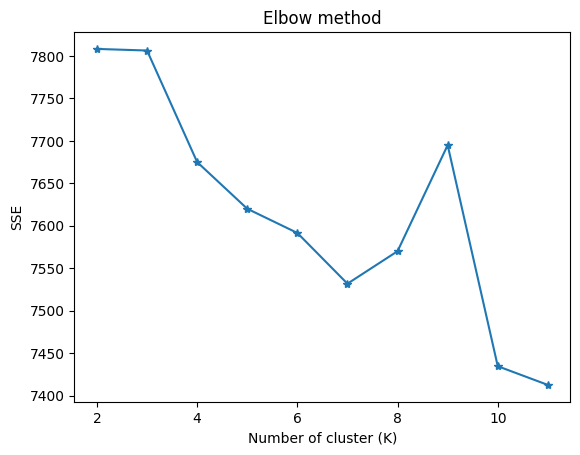

Number of clusters:
 - K:2 => Silhouette coeff.: 0.015169660436808865
 - K:3 => Silhouette coeff.: 0.015750916701763002
 - K:4 => Silhouette coeff.: 0.003178497306193015
 - K:5 => Silhouette coeff.: 0.019506843667548346
 - K:6 => Silhouette coeff.: 0.01983633484047938
 - K:7 => Silhouette coeff.: 0.021130919386708774
 - K:8 => Silhouette coeff.: 0.021753148046420017
 - K:9 => Silhouette coeff.: 0.012849554086024027
 - K:10 => Silhouette coeff.: 0.02484417224237117
 - K:11 => Silhouette coeff.: 0.02432130190616622


In [ ]:
# use elbow method and silhouette score to estimate the number of clusters
kmeans = KMeansHelper()

_ = kmeans.elbow_method(tfidf_corpus, 2, 12)
_ = kmeans.silhouette_score(tfidf_corpus, 2, 12)

Cluster 0 =>
 - size: 4140
 - main tokens: ['meeting' 'information' 'group' 'people' 'question']
 - unique main tokens: ['meeting' 'group' 'people' 'question' 'number']
 - random samples: [2449  207  665]
Cluster 1 =>
 - size: 286
 - main tokens: ['deal' 'contract' 'volume' 'price' 'transaction']
 - unique main tokens: ['deal' 'volume' 'transaction' 'meter' 'book']
 - random samples: [ 466 4026 1914]
Cluster 2 =>
 - size: 1733
 - main tokens: ['market' 'price' 'gas' 'power' 'customer']
 - unique main tokens: ['market' 'gas' 'power' 'customer' 'energy']
 - random samples: [2059 3728 6403]
Cluster 3 =>
 - size: 452
 - main tokens: ['affiliate' 'use' 'contract' 'acceptance' 'property']
 - unique main tokens: ['affiliate' 'use' 'acceptance' 'property' 'reply']
 - random samples: [7544 5495 8023]
Cluster 4 =>
 - size: 468
 - main tokens: ['message' 'information' 'error' 'attachment' 'communication']
 - unique main tokens: ['message' 'error' 'attachment' 'communication' 'dissemination']
 - r

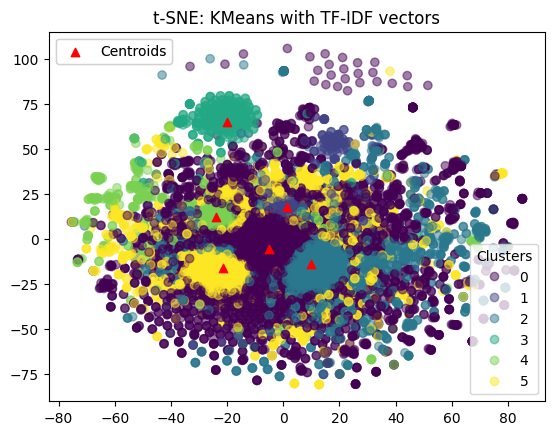

In [ ]:
# number of clusters
K = 6
# number of tokens with the highest tf-idf score to show per cluster
W = 5

clusters, centroids = kmeans.fit_predict(tfidf_corpus, K)

# for each cluster, sort the token indexes according to their tf-idf score (descending order)
argsort_tokens = (np.argsort(centroids, axis=1)[:, ::-1])
# find the index of W tokens with the highest tf-idf score that are not among
# W tokens with the highest tf-idf score in other clusters
unique_main_tk_idxs = np.full((K, W), -1)

for k in range(K):
    counter = 0
    for tk_idx in argsort_tokens[k]:
        if tk_idx not in np.delete(argsort_tokens[:, :W], k, axis=0) and tk_idx not in unique_main_tk_idxs:
            unique_main_tk_idxs[k, counter] = tk_idx
            counter += 1
        if counter == W:
            break

    main_tokens = tfidf_vectorizer.get_feature_names_out()[argsort_tokens[k, :W]]
    unique_main_tokens = tfidf_vectorizer.get_feature_names_out()[unique_main_tk_idxs[k]]
    idx_docs_in_cluster = np.flatnonzero(clusters == k)

    print(f"Cluster {k} =>")
    print(f" - size: {len(idx_docs_in_cluster)}")
    print(f" - main tokens: {main_tokens}")
    print(f" - unique main tokens: {unique_main_tokens}")
    print(f" - random samples: {np.random.choice(idx_docs_in_cluster, 3)}")
print()

# documents and centroids as points in a n-dimensional space
points_nD = np.concatenate((centroids, tfidf_corpus.toarray()))

# t-SNE to reduce the number of dimensions
tsne = TSNE(n_components=2, perplexity=25)
points_2D = tsne.fit_transform(points_nD)

# plot the clusters with their centroids
fig, ax = plt.subplots()
scatter_docs = ax.scatter(points_2D[K:, 0], points_2D[K:, 1], c=clusters, alpha=0.5)
scatter_cens = ax.scatter(points_2D[:K, 0], points_2D[:K, 1], c=["red"], alpha=1.0, marker='^', label="Centroids")
legend_docs = ax.legend(*scatter_docs.legend_elements(), loc="lower right", title="Clusters")
legend_cens = ax.legend(handles=[scatter_cens], loc="upper left")
ax.add_artist(legend_docs)
ax.add_artist(legend_cens)
plt.title("t-SNE: KMeans with TF-IDF vectors")
plt.show()

## Word2Vect

In [ ]:
# if True the word2vect model is trained using the corpus
# otherwise a pre-trained model is downloaded
train = True
# the norm that must be used ["l1", "l2"]
norm = "l2"
# skip tokens that do not have a relative document frequency in this range
min_df = 0.05
max_df = 1.00

# compute / download word vectors
word2vector :np.ndarray
if train:
    model = gensim.models.Word2Vec(tokenized_corpus, vector_size=50)
    word2vector = model.wv
else:
    word2vector = gensim.downloader.load("word2vec-google-news-300")

# vectorizer used to compute the tf-idf score
tfidf_vectorizer =  TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, min_df=min_df, max_df=max_df).fit(tokenized_corpus)

# define the vocabolary shared by the word2vect model and the tf-idf vectorizer
voc = set(tfidf_vectorizer.get_feature_names_out())
for tk in tfidf_vectorizer.vocabulary_.keys():
    if tk not in word2vector.key_to_index:
        voc.remove(tk)

d2v = myDoc2Vec(
    word2vector,
    TfidfVectorizer(tokenizer=identity_tokenizer, token_pattern=None, lowercase=False, norm=norm, vocabulary=voc)
)

# process the corpus
vec_corpus = d2v.transform(tokenized_corpus)

In [ ]:
# random example
idx = np.random.randint(0, len(tokenized_corpus))

print(corpus.iloc[idx, 6])
print(tokenized_corpus[idx])

d2v.w2v.most_similar(vec_corpus[idx], topn=5)

## K-Means with myDoc2Vec

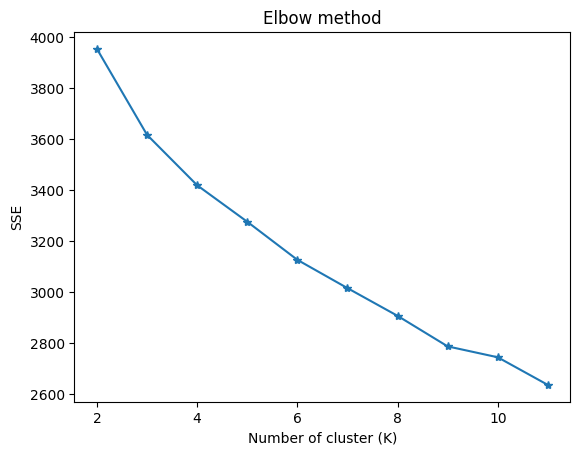

Number of clusters:
 - K:2 => Silhouette coeff.: 0.10455881036147326
 - K:3 => Silhouette coeff.: 0.11530133677398084
 - K:4 => Silhouette coeff.: 0.10386032779781125
 - K:5 => Silhouette coeff.: 0.11977125672477862
 - K:6 => Silhouette coeff.: 0.11172659744298509
 - K:7 => Silhouette coeff.: 0.13047523626288843
 - K:8 => Silhouette coeff.: 0.12254928729648272
 - K:9 => Silhouette coeff.: 0.13128673459998508
 - K:10 => Silhouette coeff.: 0.15250731935412118
 - K:11 => Silhouette coeff.: 0.1531757031593712


In [ ]:
# use elbow method and silhouette score to estimate the number of clusters
kmeans = KMeansHelper()

_ = kmeans.elbow_method(vec_corpus, 2, 12)
_ = kmeans.silhouette_score(vec_corpus, 2, 12)

Cluster 0 =>
 - size: 1584
 - main tokens: [('lead', 0.9159246683120728), ('working', 0.9137210845947266), ('metric', 0.8937644958496094), ('tenure', 0.890984058380127), ('affair', 0.8901671767234802)]
 - random samples: [5557 2027 4795  347 5982 3831  576 4699 3973 5307]
Cluster 1 =>
 - size: 150
 - main tokens: [('member', 0.8716219663619995), ('special', 0.855044960975647), ('registrant', 0.8361210823059082), ('promotion', 0.8359642028808594), ('membership', 0.8302205801010132)]
 - random samples: [3724 4092 5473 6468 3515 6422 5384 5821 5918 4600]
Cluster 2 =>
 - size: 1742
 - main tokens: [('objection', 0.9434015154838562), ('netting', 0.9273972511291504), ('clause', 0.9254519939422607), ('guaranty', 0.9217105507850647), ('negotiation', 0.9217071533203125)]
 - random samples: [5465 7430 4965 7372 6486 7910 6562 4516 4344 2683]
Cluster 3 =>
 - size: 1173
 - main tokens: [('original', 0.904836893081665), ('correspondence', 0.8886016607284546), ('important', 0.8865550756454468), ('at

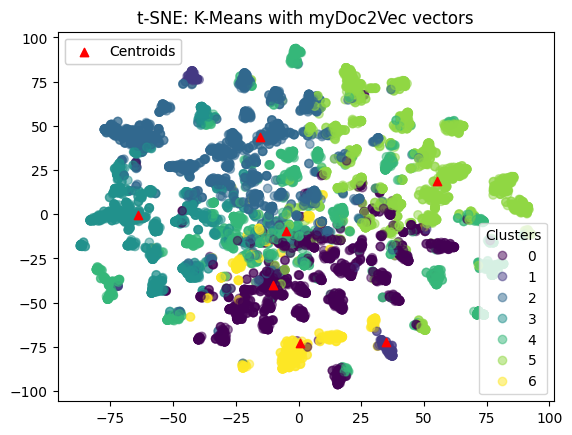

In [ ]:
# number of clusters
K = 7
# Number of most similar tokens to show per cluster
W = 5

clusters, centroids = kmeans.fit_predict(vec_corpus, K)

for k in range(K):
    idx_docs_in_cluster = np.flatnonzero(clusters == k)

    print(f"Cluster {k} =>")
    print(f" - size: {len(idx_docs_in_cluster)}")
    print(f" - main tokens: {d2v.w2v.most_similar(centroids[k], topn=W)}")
    print(f" - random samples: {np.random.choice(idx_docs_in_cluster, 10)}")
print()

# documents and centroids as points in a n-dimensional space
points_nD = np.concatenate((centroids, vec_corpus))

# t-SNE to reduce the number of dimensions
tsne = TSNE(n_components=2, perplexity=25)
points_2D = tsne.fit_transform(points_nD)

# plot the clusters with their centroids
fig, ax = plt.subplots()
scatter_docs = ax.scatter(points_2D[K:, 0], points_2D[K:, 1], c=clusters, alpha=0.5)
scatter_cens = ax.scatter(points_2D[:K, 0], points_2D[:K, 1], c=["red"], alpha=1.0, marker='^', label="Centroids")
legend_docs = ax.legend(*scatter_docs.legend_elements(), loc="lower right", title="Clusters")
legend_cens = ax.legend(handles=[scatter_cens], loc="upper left")
ax.add_artist(legend_docs)
ax.add_artist(legend_cens)
plt.title("t-SNE: K-Means with myDoc2Vec vectors")
plt.show()

In [ ]:
print(corpus.iloc[45    , 6])

thx




Jeanie Slone
12/19/2000 04:51 PM
To: John Arnold/HOU/ECT@ECT
cc:  
Subject: confidential employee information-dutch quigley

Dutch requested a meeting with me today and I gave him the scoop on the 
promotion.  I will follow-up with him after our meeting the first week of 
Jan.  He was ok with everything.  let me know if you need anything else.
---------------------- Forwarded by Jeanie Slone/HOU/ECT on 12/19/2000 04:45 
PM ---------------------------


Jeanie Slone
12/19/2000 10:09 AM
To: John Arnold/HOU/ECT@ECT
cc: Ted C Bland/HOU/ECT@ECT, David Oxley/HOU/ECT@ECT 

Subject: confidential employee information-dutch quigley

John,
As we discussed earlier, ENA HR is working with the A/A program to develop a 
process for placing sr. spec into associate titles.  Unfortunately, that 
process has not been finalized and as such, Dutch is not yet an associate.  
Ted is finalizing the process this week and it will likely require Dutch to 
interview with 4 other commercial managers outsid